In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [31]:
df = pd.read_csv('../data/benin-malanville.csv')

In [32]:
# Summary Statistics
print("Summary Statistics: ")
print(df.describe())

Summary Statistics: 
                 GHI            DNI            DHI           ModA  \
count  525600.000000  525600.000000  525600.000000  525600.000000   
mean      240.559452     167.187516     115.358961     236.589496   
std       331.131327     261.710501     158.691074     326.894859   
min       -12.900000      -7.800000     -12.600000       0.000000   
25%        -2.000000      -0.500000      -2.100000       0.000000   
50%         1.800000      -0.100000       1.600000       4.500000   
75%       483.400000     314.200000     216.300000     463.700000   
max      1413.000000     952.300000     759.200000    1342.300000   

                ModB           Tamb             RH             WS  \
count  525600.000000  525600.000000  525600.000000  525600.000000   
mean      228.883576      28.179683      54.487969       2.121113   
std       316.536515       5.924297      28.073069       1.603466   
min         0.000000      11.000000       2.100000       0.000000   
25%         

In [33]:
# Missing-Value Report
missing_values = df.isna().sum()
print("\nMissing Values per Column: ")
print(missing_values)


Missing Values per Column: 
Timestamp             0
GHI                   0
DNI                   0
DHI                   0
ModA                  0
ModB                  0
Tamb                  0
RH                    0
WS                    0
WSgust                0
WSstdev               0
WD                    0
WDstdev               0
BP                    0
Cleaning              0
Precipitation         0
TModA                 0
TModB                 0
Comments         525600
dtype: int64


In [34]:
# Columns with >5% missing values
total_rows = len(df)
cols_over_5_percent = missing_values[missing_values > 0.05 * total_rows].index.tolist()
print("\nColumns with >5% Missing Values: ")
print(cols_over_5_percent)


Columns with >5% Missing Values: 
['Comments']


In [35]:
# Missing Values in Key Columns
key_cols = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust']

missing_key = df[key_cols].isna().sum()
print("Missing Values in Key Columns:")
print(missing_key)


Missing Values in Key Columns:
GHI       0
DNI       0
DHI       0
ModA      0
ModB      0
WS        0
WSgust    0
dtype: int64


In [36]:
# Basic Range Checks (Incorrect Entries)
incorrect = {}

for col in key_cols:
    incorrect[col] = df[df[col] < 0].shape[0]

print("Incorrect (negative) values per column:")
print(incorrect)


Incorrect (negative) values per column:
{'GHI': 258847, 'DNI': 275987, 'DHI': 259182, 'ModA': 0, 'ModB': 0, 'WS': 0, 'WSgust': 0}


In [37]:
# Outlier Detection Using IQR (Interquartile Range)
import numpy as np

def iqr_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return series[(series < lower_bound) | (series > upper_bound)]

for col in key_cols:
    outliers = iqr_outliers(df[col])
    print(f"{col}: {len(outliers)} outliers")


GHI: 145 outliers
DNI: 15196 outliers
DHI: 8733 outliers
ModA: 98 outliers
ModB: 240 outliers
WS: 6717 outliers
WSgust: 5368 outliers


In [38]:
# Quick Summary of Data Quality for Key Columns
summary = pd.DataFrame({
    'missing_values': df[key_cols].isna().sum(),
    'negative_values': [ (df[df[col] < 0].shape[0]) for col in key_cols ],
    'std_dev': df[key_cols].std(),
    'mean': df[key_cols].mean()
}, index=key_cols)

print(summary)


        missing_values  negative_values     std_dev        mean
GHI                  0           258847  331.131327  240.559452
DNI                  0           275987  261.710501  167.187516
DHI                  0           259182  158.691074  115.358961
ModA                 0                0  326.894859  236.589496
ModB                 0                0  316.536515  228.883576
WS                   0                0    1.603466    2.121113
WSgust               0                0    2.029120    2.809195


In [56]:
# Z-scores for the specified columns and flag rows where |Z| > 3


# Columns to analyze
cols = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust']

# Compute Z-scores
z_scores = (df[cols] - df[cols].mean()) / df[cols].std()

# Flag rows with |Z| > 3
outlier_rows = df[(np.abs(z_scores) > 3).any(axis=1)]

print("Number of rows with Z-score > 3:")
print(len(outlier_rows))

print("\nOutlier rows:")
outlier_rows.head()


Number of rows with Z-score > 3:
7740

Outlier rows:


,Timestamp,GHI,DNI,DHI,ModA,ModB,Tamb,RH,WS,WSgust,...,WDstdev,BP,Cleaning,Precipitation,TModA,TModB,Comments,Month,Hour,CleaningFlag
670,2021-08-09 11:11:00,836.0,235.0,610.6,778.8,783.8,30.3,68.2,3.2,4.1,...,18.4,999,0,0.0,63.0,52.7,NaN,8,11,Dirty
671,2021-08-09 11:12:00,1274.0,698.8,615.2,1210.3,1210.3,30.1,69.6,3.4,4.1,...,13.3,999,0,0.0,63.7,53.1,NaN,8,11,Dirty
672,2021-08-09 11:13:00,938.0,340.1,612.8,891.1,891.1,30.4,68.4,3.4,4.6,...,11.9,999,0,0.0,65.8,54.3,NaN,8,11,Dirty
673,2021-08-09 11:14:00,718.5,126.8,593.2,682.6,682.6,30.6,68.2,4.7,5.6,...,8.0,999,0,0.0,65.4,54.2,NaN,8,11,Dirty
674,2021-08-09 11:15:00,1349.0,771.8,618.0,1281.5,1281.5,30.9,67.1,4.0,4.6,...,12.3,999,0,0.0,65.0,53.5,NaN,8,11,Dirty


In [40]:
# Drop or impute (median) missing values in key columns

# Key columns to clean
key_cols = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust']

# Drop or impute missing values
total_rows = len(df)

for col in key_cols:
    missing = df[col].isna().sum()
    threshold = 0.05 * total_rows   # 5% threshold
    
    if missing > threshold:
        # Impute with median
        df[col] = df[col].fillna(df[col].median())
    else:
        # Drop rows where this column is missing
        df = df.dropna(subset=[col])

# Confirm cleanup
df[key_cols].isna().sum()


GHI       0
DNI       0
DHI       0
ModA      0
ModB      0
WS        0
WSgust    0
dtype: int64

In [41]:
# Export cleaned DataFrame
output_path = '../data/benin_clean.csv'
df.to_csv(output_path, index=False)

print("Cleaned file saved to:", output_path)


Cleaned file saved to: ../data/benin_clean.csv


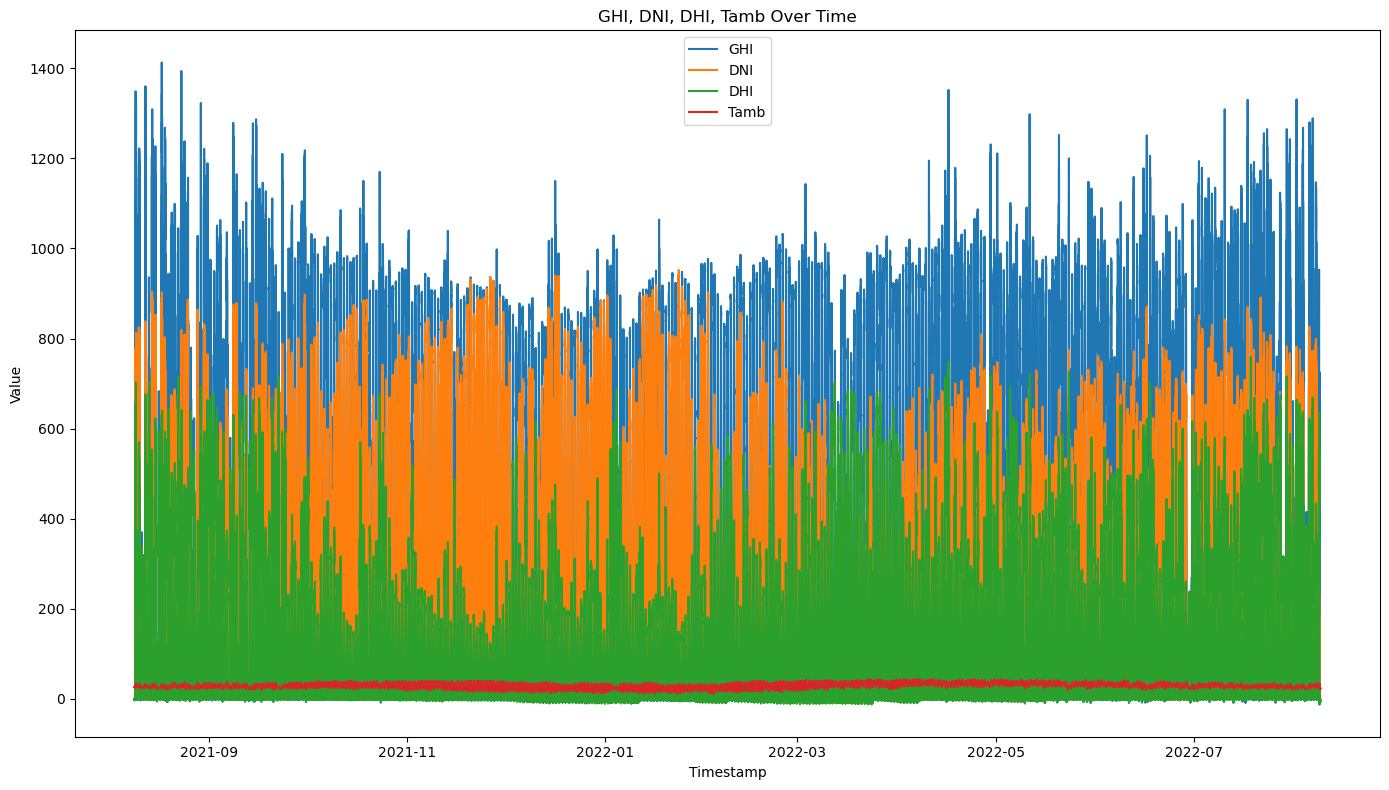

In [42]:
# Line or bar charts of GHI, DNI, DHI, Tamb vs. Timestamp.

# Ensure Timestamp is datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Columns to plot
cols = ['GHI', 'DNI', 'DHI', 'Tamb']

plt.figure(figsize=(14, 8))

for col in cols:
    plt.plot(df['Timestamp'], df[col], label=col)

plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.title('GHI, DNI, DHI, Tamb Over Time')
plt.legend()
plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

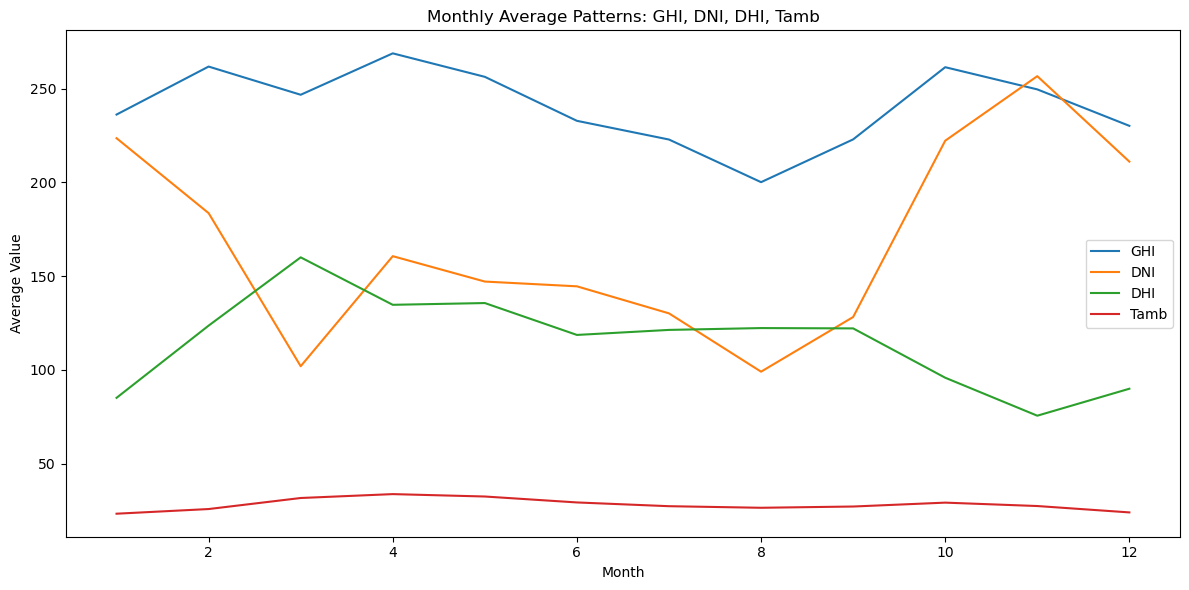

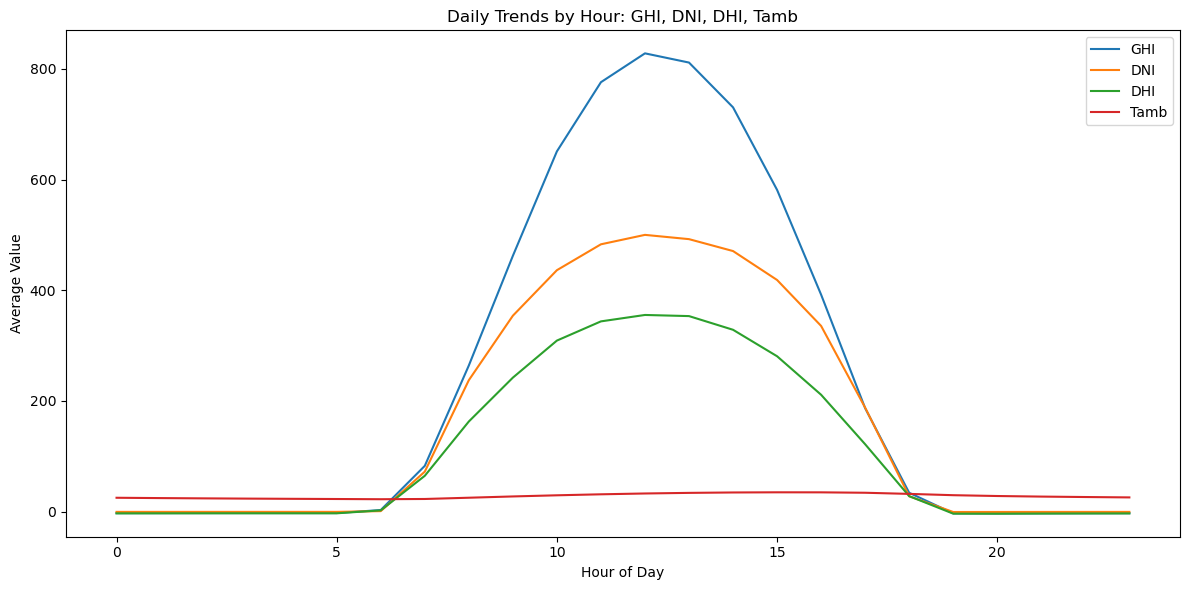

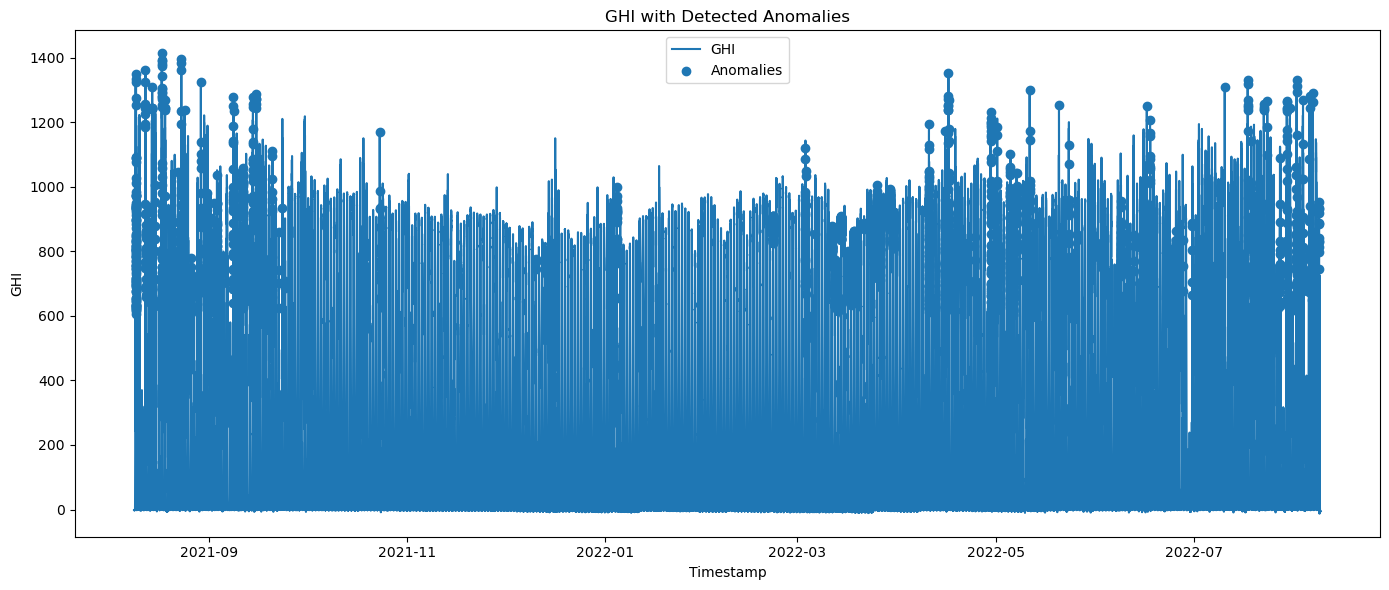

In [43]:
# Ensure timestamp is datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Create month and hour columns
df['Month'] = df['Timestamp'].dt.month
df['Hour'] = df['Timestamp'].dt.hour

# 1. Monthly patterns (average by month)
monthly_avg = df.groupby('Month')[['GHI', 'DNI', 'DHI', 'Tamb']].mean()

# 2. Daily trends (average by hour)
hourly_avg = df.groupby('Hour')[['GHI', 'DNI', 'DHI', 'Tamb']].mean()

# 3. Detect anomalies using Z-scores
from scipy.stats import zscore
cols = ['GHI', 'DNI', 'DHI', 'Tamb']
z = df[cols].apply(zscore)
anomalies = df[(abs(z) > 3).any(axis=1)]

# 4. Plots
import matplotlib.pyplot as plt

# Monthly pattern plot
plt.figure(figsize=(12,6))
monthly_avg.plot(figsize=(12,6))
plt.title("Monthly Average Patterns: GHI, DNI, DHI, Tamb")
plt.xlabel("Month")
plt.ylabel("Average Value")
plt.tight_layout()
plt.show()

# Daily trend plot
hourly_avg.plot(figsize=(12,6))
plt.title("Daily Trends by Hour: GHI, DNI, DHI, Tamb")
plt.xlabel("Hour of Day")
plt.ylabel("Average Value")
plt.tight_layout()
plt.show()

# Anomaly plot (GHI example)
plt.figure(figsize=(14,6))
plt.plot(df['Timestamp'], df['GHI'], label='GHI')
plt.scatter(anomalies['Timestamp'], anomalies['GHI'], marker='o', label='Anomalies')
plt.title("GHI with Detected Anomalies")
plt.xlabel("Timestamp")
plt.ylabel("GHI")
plt.legend()
plt.tight_layout()
plt.show()

                    ModA        ModB
CleaningFlag                        
Clean         232.393310  225.026584
Dirty         517.343618  486.943256


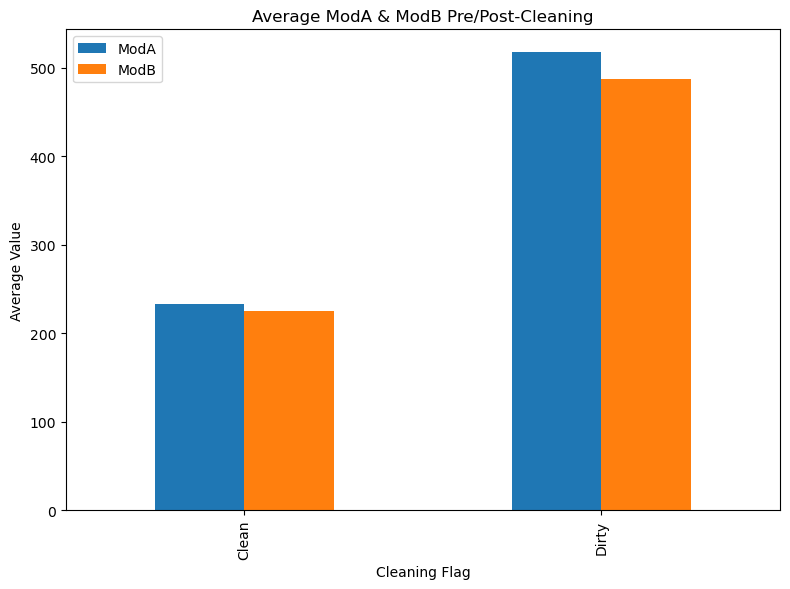

In [44]:
# Group by cleaning flag and compute average ModA & ModB
# Ensure CleaningFlag exists
if 'CleaningFlag' not in df.columns:
    from scipy.stats import zscore
    key_cols = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust']
    z_scores = df[key_cols].apply(zscore, nan_policy='omit')
    df['CleaningFlag'] = ['Dirty' if any(abs(row) > 3 for row in z_scores.iloc[i]) else 'Clean' 
                          for i in range(len(df))]

# Group by CleaningFlag and compute average ModA & ModB
clean_group = df.groupby('CleaningFlag')[['ModA', 'ModB']].mean()
print(clean_group)

# Plot
clean_group.plot(kind='bar', figsize=(8,6), title='Average ModA & ModB Pre/Post-Cleaning')
plt.ylabel('Average Value')
plt.xlabel('Cleaning Flag')
plt.tight_layout()
plt.show()

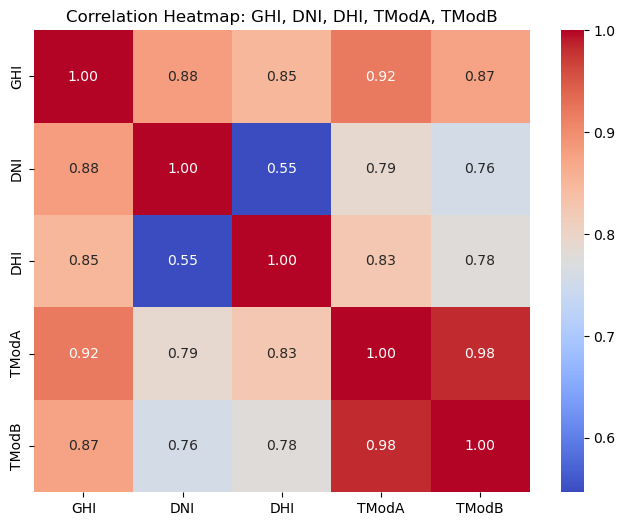

In [45]:
# Heatmap of correlations (GHI, DNI, DHI, TModA, TModB).

# Select columns for correlation
cols = ['GHI', 'DNI', 'DHI', 'TModA', 'TModB']

# Compute correlation matrix
corr_matrix = df[cols].corr()

# Plot heatmap
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Heatmap: GHI, DNI, DHI, TModA, TModB')
plt.show()

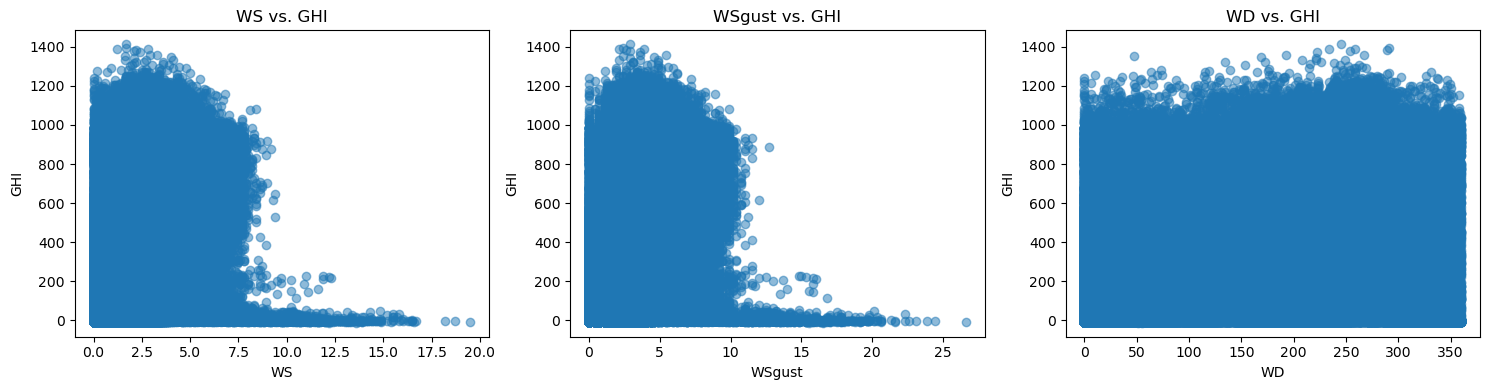

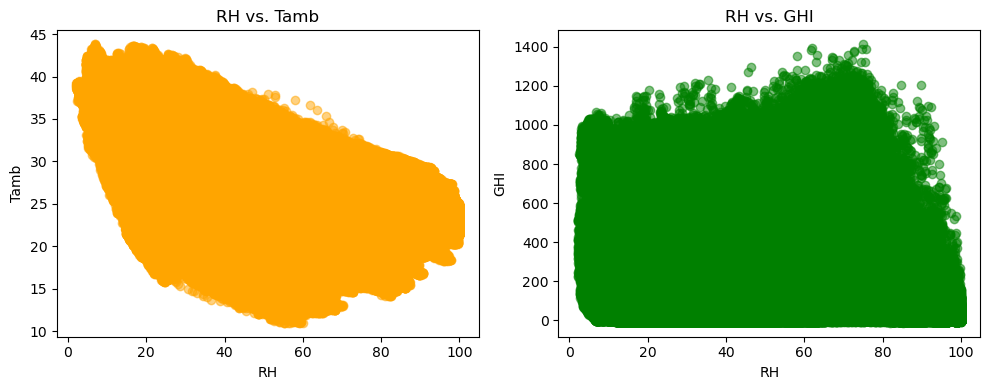

In [46]:
# Scatter plots: WS, WSgust, WD vs. GHI
scatter_cols = ['WS', 'WSgust', 'WD']
plt.figure(figsize=(15,4))

for i, col in enumerate(scatter_cols, 1):
    plt.subplot(1, 3, i)
    plt.scatter(df[col], df['GHI'], alpha=0.5)
    plt.xlabel(col)
    plt.ylabel('GHI')
    plt.title(f'{col} vs. GHI')

plt.tight_layout()
plt.show()

# Scatter plots: RH vs. Tamb and RH vs. GHI
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.scatter(df['RH'], df['Tamb'], alpha=0.5, color='orange')
plt.xlabel('RH')
plt.ylabel('Tamb')
plt.title('RH vs. Tamb')

plt.subplot(1,2,2)
plt.scatter(df['RH'], df['GHI'], alpha=0.5, color='green')
plt.xlabel('RH')
plt.ylabel('GHI')
plt.title('RH vs. GHI')

plt.tight_layout()
plt.show()

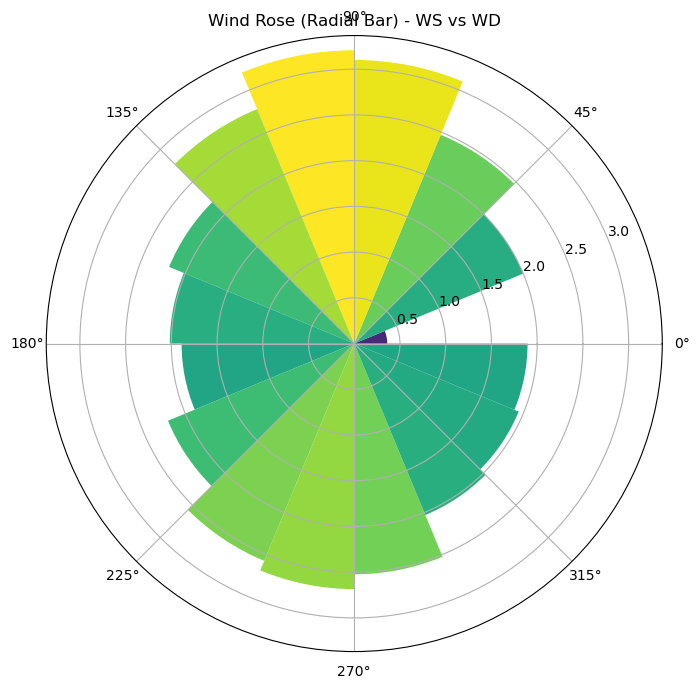

In [52]:
# Wind rose or radial bar plot of WS/WD.


# Bin the wind direction into 16 compass sectors
num_bins = 16
wd_bins = np.linspace(0, 360, num_bins + 1)
wd_labels = (wd_bins[:-1] + wd_bins[1:]) / 2  # midpoints for plotting

# Compute average wind speed per direction bin
ws_mean_per_bin = []
for i in range(num_bins):
    mask = (df['WD'] >= wd_bins[i]) & (df['WD'] < wd_bins[i+1])
    ws_mean_per_bin.append(df.loc[mask, 'WS'].mean())

# Convert angles to radians for polar plot
angles = np.deg2rad(wd_labels)

# Radial bar plot
plt.figure(figsize=(8,8))
ax = plt.subplot(111, polar=True)
bars = ax.bar(angles, ws_mean_per_bin, width=(2*np.pi/num_bins), bottom=0.0, color=plt.cm.viridis(ws_mean_per_bin/np.nanmax(ws_mean_per_bin)))

# Add title
plt.title("Wind Rose (Radial Bar) - WS vs WD", va='bottom')
plt.show()


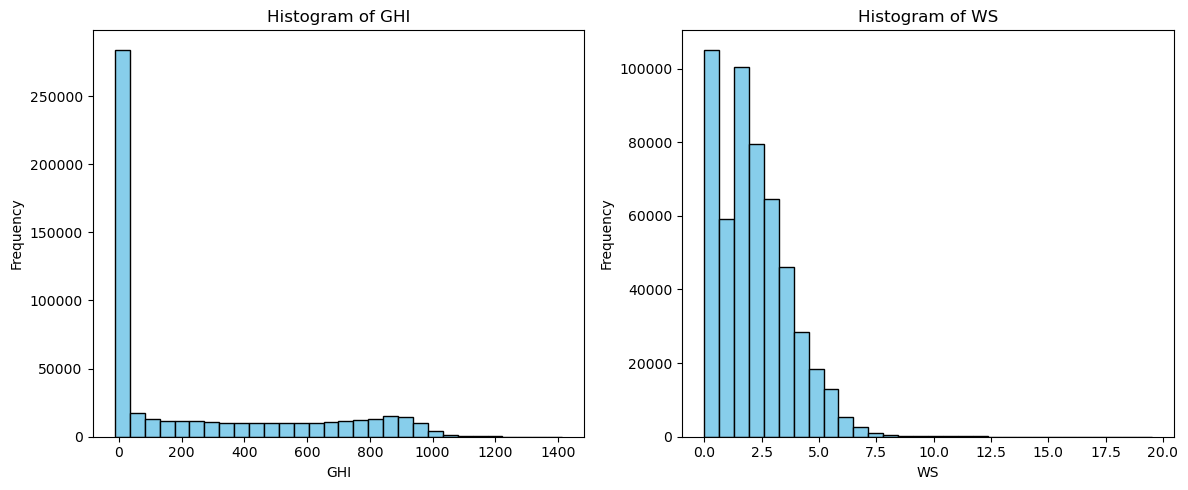

In [53]:
# Histograms for GHI and one other variable (e.g., WS).

# Variables to plot
vars_to_plot = ['GHI', 'WS']

plt.figure(figsize=(12,5))

for i, col in enumerate(vars_to_plot, 1):
    plt.subplot(1, 2, i)
    plt.hist(df[col].dropna(), bins=30, color='skyblue', edgecolor='black')
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

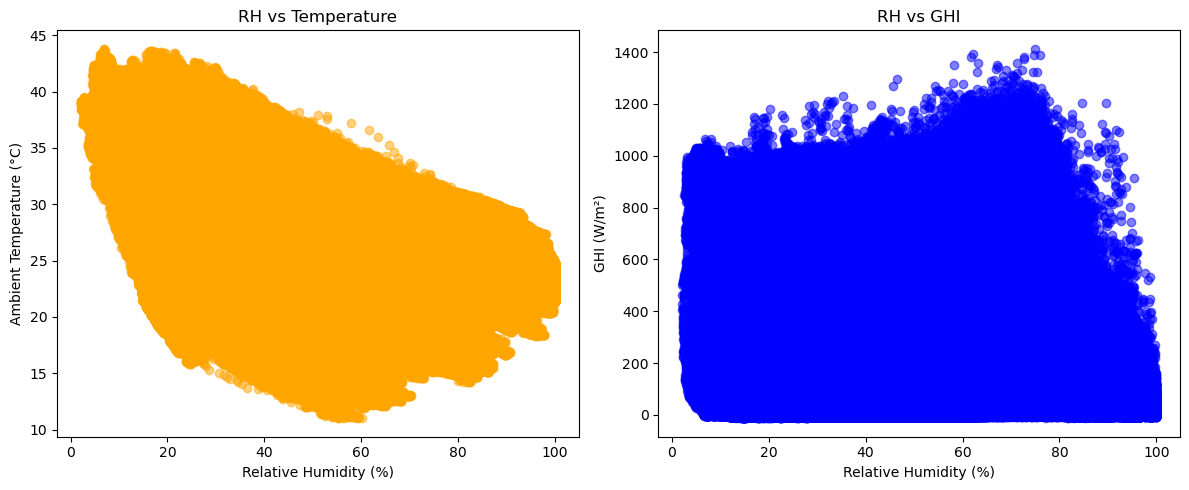

Correlation RH vs Temperature: -0.41
Correlation RH vs GHI: -0.36


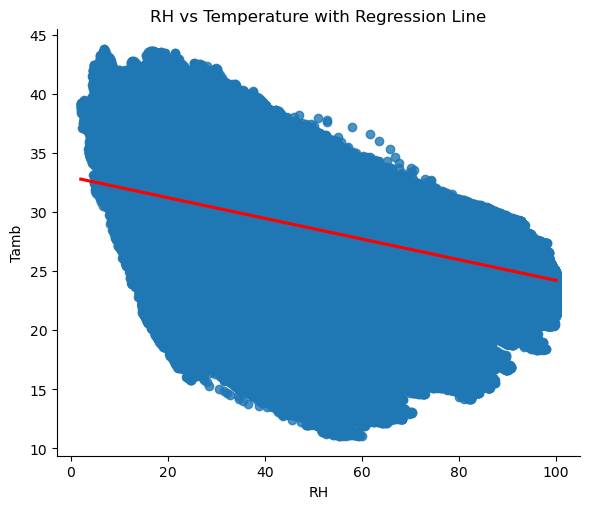

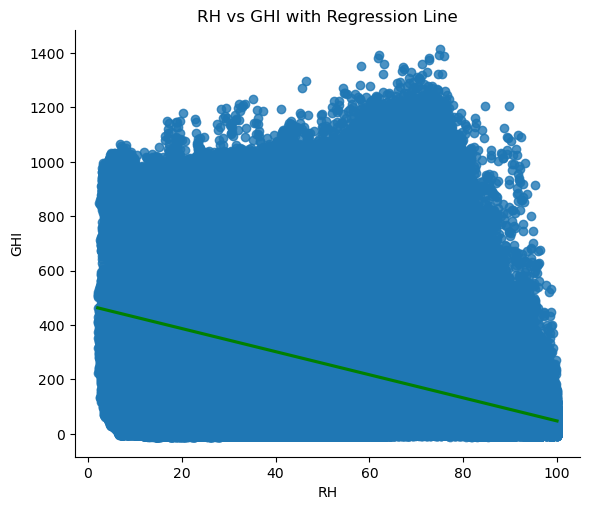

In [54]:
# Examine how relative humidity (RH) might influence temperature readings and solar radiation.


# 1️⃣ Scatter plots to visually assess relationships
plt.figure(figsize=(12,5))

# RH vs Temperature
plt.subplot(1,2,1)
plt.scatter(df['RH'], df['Tamb'], alpha=0.5, color='orange')
plt.xlabel('Relative Humidity (%)')
plt.ylabel('Ambient Temperature (°C)')
plt.title('RH vs Temperature')

# RH vs GHI
plt.subplot(1,2,2)
plt.scatter(df['RH'], df['GHI'], alpha=0.5, color='blue')
plt.xlabel('Relative Humidity (%)')
plt.ylabel('GHI (W/m²)')
plt.title('RH vs GHI')

plt.tight_layout()
plt.show()

# 2️⃣ Compute correlation coefficients
corr_temp = df[['RH','Tamb']].corr().iloc[0,1]
corr_ghi = df[['RH','GHI']].corr().iloc[0,1]

print(f"Correlation RH vs Temperature: {corr_temp:.2f}")
print(f"Correlation RH vs GHI: {corr_ghi:.2f}")

# 3️⃣ Optional: Use a regression line for better trend visualization
sns.lmplot(x='RH', y='Tamb', data=df, aspect=1.2, line_kws={'color':'red'})
plt.title('RH vs Temperature with Regression Line')
plt.show()

sns.lmplot(x='RH', y='GHI', data=df, aspect=1.2, line_kws={'color':'green'})
plt.title('RH vs GHI with Regression Line')
plt.show()


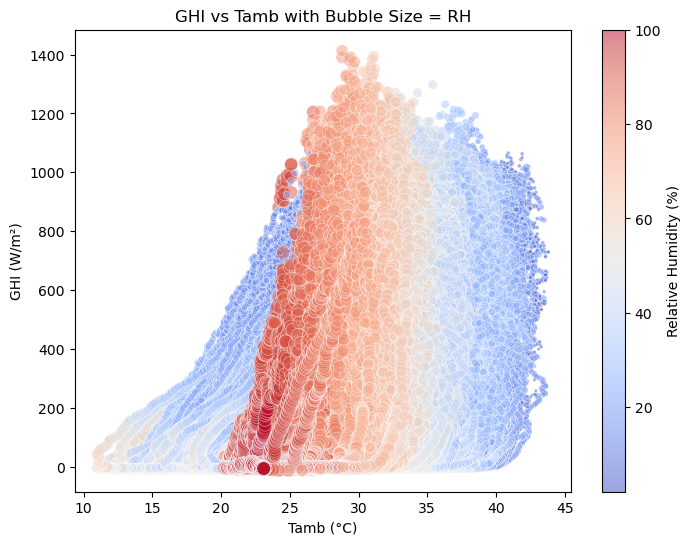

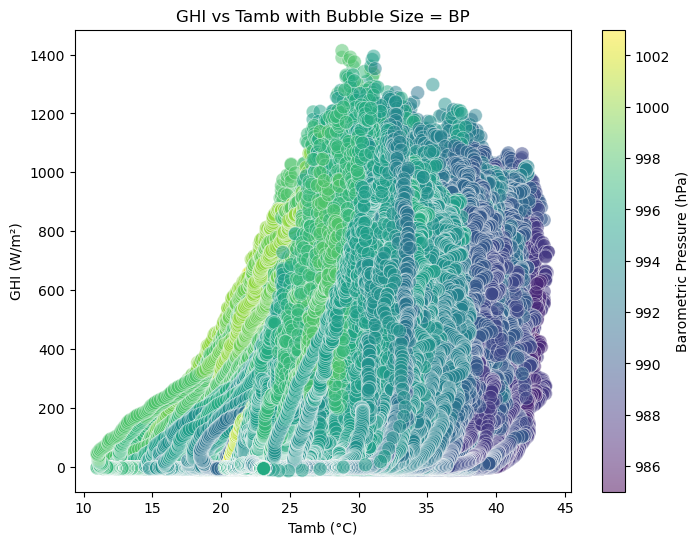

In [55]:
# GHI vs. Tamb with bubble size = RH or BP.


# Bubble size = RH
plt.figure(figsize=(8,6))
plt.scatter(df['Tamb'], df['GHI'], 
            s=df['RH'],            # bubble size
            alpha=0.5, 
            c=df['RH'],            # color by RH
            cmap='coolwarm', 
            edgecolors='w', 
            linewidth=0.5)
plt.xlabel('Tamb (°C)')
plt.ylabel('GHI (W/m²)')
plt.title('GHI vs Tamb with Bubble Size = RH')
cbar = plt.colorbar()
cbar.set_label('Relative Humidity (%)')
plt.show()

# Bubble size = BP (if column exists)
if 'BP' in df.columns:
    plt.figure(figsize=(8,6))
    plt.scatter(df['Tamb'], df['GHI'], 
                s=df['BP']/10,       # scale down for visibility
                alpha=0.5, 
                c=df['BP'], 
                cmap='viridis', 
                edgecolors='w', 
                linewidth=0.5)
    plt.xlabel('Tamb (°C)')
    plt.ylabel('GHI (W/m²)')
    plt.title('GHI vs Tamb with Bubble Size = BP')
    cbar = plt.colorbar()
    cbar.set_label('Barometric Pressure (hPa)')
    plt.show()
